# What's Cooking? 🍜

This Kaggle competition asks us to predict the category of a dish's cuisine given a list of its ingredients.  <br><br>
This notebook provides a step-by-step analysis and solution to the given problem. 
It is divided into four main sections: 
- Exploratory Analysis - as a first step, we explore the main characteristics of the data with;
- Text Processing & Feature Engineering  - here we apply some basic text processing techniques in order to clean and prepare the data for model development ; 
- Data Modeling - in this section we build  some predictive model of the cuisine (Logistic Regression, LinearSVC,Random Forest, XGBoost and so on). 
- Models comparison - here we will see which model perform better in term of accuracy, variance and execution time <br>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [1]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")


In [2]:
from pandas import Series, DataFrame
import pandas as pd
import numpy as np
import nltk
import re
from nltk.stem import WordNetLemmatizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
import sklearn.metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from pprint import pprint
from time import time
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
import sklearn.model_selection as ms
from lightgbm import LGBMClassifier
import xgboost as xgb
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import StratifiedKFold



sns.set_context('talk')

  # I.What's Cooking? - Exploratory Analysis

In [3]:
traindf = pd.read_json('train.json', orient='columns')
testdf = pd.read_json('test.json', orient='columns')

#### *First look of the training data:*

In [4]:
traindf.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


In [7]:
traindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
cuisine        39774 non-null object
id             39774 non-null int64
ingredients    39774 non-null object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB


In [5]:
traindf.shape # 39774 observations, 3 columns

(39774, 3)

In [13]:
print("The training data consists of {} recipes".format(len(traindf)))

The training data consists of 39774 recipes


In [4]:
print("First ten elements in our training sample:")
traindf.head(10)

First ten elements in our training sample:


,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."
5,jamaican,6602,"[plain flour, sugar, butter, eggs, fresh ginge..."
6,spanish,42779,"[olive oil, salt, medium shrimp, pepper, garli..."
7,italian,3735,"[sugar, pistachio nuts, white almond bark, flo..."
8,mexican,16903,"[olive oil, purple onion, fresh pineapple, por..."
9,italian,12734,"[chopped tomatoes, fresh basil, garlic, extra-..."


#### *Let's Take a quick look on test sample also:*

In [6]:
testdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9944 entries, 0 to 9943
Data columns (total 2 columns):
id             9944 non-null int64
ingredients    9944 non-null object
dtypes: int64(1), object(1)
memory usage: 155.5+ KB


In [8]:
testdf.shape # 9944 observations, 2 columns

(9944, 2)

In [17]:
print("The test data consists of {} recipes".format(len(testdf)))

The test data consists of 9944 recipes


In [5]:
print("First ten elements in our test sample:")
testdf.head(10)

First ten elements in our test sample:


,id,ingredients
0,18009,"[baking powder, eggs, all-purpose flour, raisi..."
1,28583,"[sugar, egg yolks, corn starch, cream of tarta..."
2,41580,"[sausage links, fennel bulb, fronds, olive oil..."
3,29752,"[meat cuts, file powder, smoked sausage, okra,..."
4,35687,"[ground black pepper, salt, sausage casings, l..."
5,38527,"[baking powder, all-purpose flour, peach slice..."
6,19666,"[grape juice, orange, white zinfandel]"
7,41217,"[ground ginger, white pepper, green onions, or..."
8,28753,"[diced onions, taco seasoning mix, all-purpose..."
9,22659,"[eggs, cherries, dates, dark muscovado sugar, ..."


The test and train data provided in this Kaggle competition are in json format. We have imported the data as a data frame object and the above lines of code show us the initial look of both samples. We observe that each recipe is a separate row and has:
- a unique identifier - the 'id' column; 
- the type of cuisine in which this recipe falls - this is our target variable (the test sample does not have this column);
- a list object with ingredients - this will be the main source of explanatory variables in our classification problem.


### *Let's explore more in depth the target variable *

In [23]:
print("Number of cuisine (Pays) categories: {}".format(len(traindf.cuisine.unique())))
pd.DataFrame(traindf.cuisine.unique())

Number of cuisine (Pays) categories: 20


,0
0,greek
1,southern_us
2,filipino
3,indian
4,jamaican
5,spanish
6,italian
7,mexican
8,chinese
9,british


There are 20 different countries (cuisines) which we are going to predict for the test sample. <br> 
**This means that the our problem is a multi-class classification problem (there are more than 2 categories to predict).** <br>

#### Number of recipes in each cuisine category

In [29]:
traindf.groupby("cuisine")['id'].count().sort_values().transpose().reset_index().rename(columns={'cuisine':"Pays", 'id':"Number of Recipes"})

,Pays,Number of Recipes
0,brazilian,467
1,russian,489
2,jamaican,526
3,irish,667
4,filipino,755
5,british,804
6,moroccan,821
7,vietnamese,825
8,korean,830
9,spanish,989


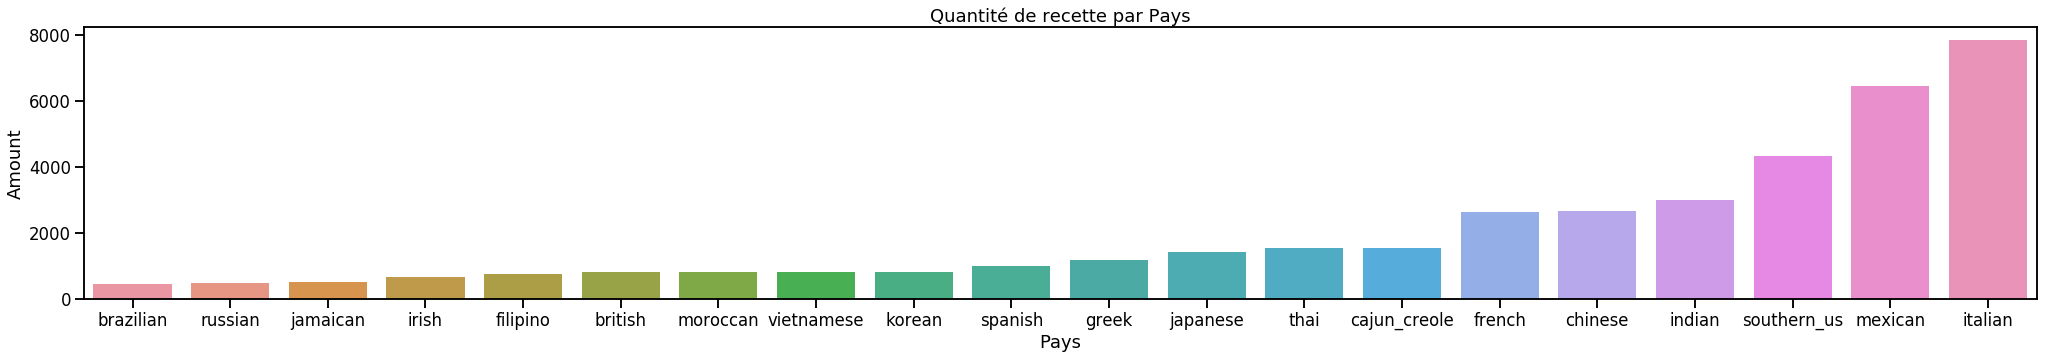

In [4]:
plt.figure(figsize=(35,5))
ax = sns.barplot("Pays","Amount",data=traindf
                 .groupby("cuisine")['id']
                 .count()
                 .sort_values()
                 .transpose()
                 .reset_index()
                 .rename(columns={'cuisine':"Pays", 'id':"Amount"}))
plt.title("Quantité de recette par Pays")
plt.show()

From the table and the plot of label distribution, we observe that the most common category in our sample is the Italian cuisine, followed by the Mexican.
The least represented cuisines are the Irish, Jamaican, Russian and Brazilian.

### * Let's take a closer look at the ingredients in our training sample *

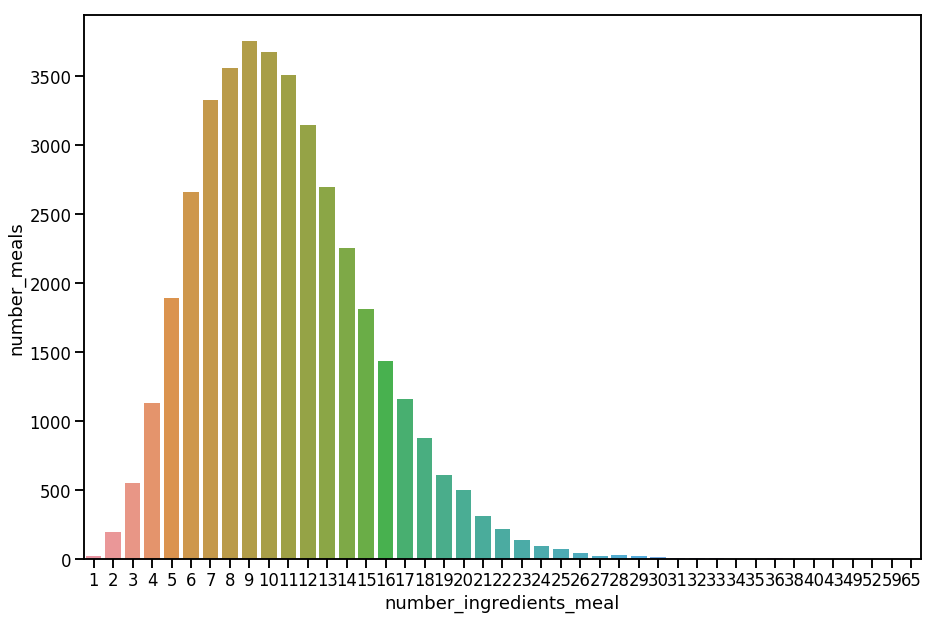

In [5]:
f, ax = plt.subplots(figsize=(15,10))
sns.barplot(x='number_ingredients_meal',
            y='number_meals',
            data= (traindf.ingredients.map(lambda l: len(l))
                    .value_counts()
                    .sort_index()
                    .reset_index()
                    .rename(columns={'index':'number_ingredients_meal', 'ingredients':'number_meals'}))
            )

The distribution of recipe length is right-skewed as we can see from the histogram above. The maximum number of ingredients is 65 and the minimum is 1.

I found some recipes which consist of only 1 ingredient like below.

water => Japanese
butter => Indian
butter => French
It could get models confused. Unfortunately, such recipes exist in the test dataset though.

#### * Let's take a quick glance at the extreme *

In [33]:
longrecipes = traindf[traindf['ingredients'].str.len() > 30]

print("Explore the ingredients in the longest recipe (65) in our training set:" + "\n")
print(str(list(longrecipes[longrecipes['ingredients'].str.len() == 65].ingredients.values)) + "\n")
print("Cuisine: " + str(list(longrecipes[longrecipes['ingredients'].str.len() == 65].cuisine)))

Explore the ingredients in the longest recipe (65) in our training set:

[['fettucine', 'fresh marjoram', 'minced garlic', 'olive oil', 'garlic powder', 'large eggs', 'Alfredo sauce', 'vegetable oil', 'cajun seasoning', 'shredded romano cheese', 'basil dried leaves', 'salt', 'cayenne pepper', 'scallions', 'red bell pepper', 'boneless skinless chicken breast halves', 'soba', 'pasta sauce', 'kosher salt', 'milk', 'fresh ginger', 'ground black pepper', 'flour', 'cooked chicken', 'coarse salt', 'lemon', 'diced tomatoes', 'garlic', 'rice vinegar', 'NeufchÃ¢tel', 'garlic cloves', 'dried parsley', 'frozen artichoke hearts', 'penne', 'pepper', 'sweet onion', 'part-skim mozzarella cheese', 'parmigiano reggiano cheese', 'basil leaves', 'onion powder', 'red wine vinegar', 'red pepper flakes', 'orzo', 'crushed red pepper', 'all-purpose flour', 'freshly ground pepper', 'sliced mushrooms', 'panko breadcrumbs', 'plum tomatoes', 'fresh basil', 'fresh leav spinach', 'water', 'sun-dried tomatoes', 'grou

65 seems beyond all that one can even imagine. So, my guess is that the case is more about wrong data in our sample.   

In [37]:
shortrecipes = traindf[traindf['ingredients'].str.len() <= 2]

print("Explore the ingredients in the shortest recipes in our training set:" + "\n")
print(list(traindf[traindf['ingredients'].str.len() == 1].ingredients.values))
print("And there corresponding labels" + "\n")
print(list(traindf[traindf['ingredients'].str.len() == 1].cuisine.values))


Explore the ingredients in the shortest recipes in our training set:

[['sushi rice'], ['dried rice noodles'], ['plain low-fat yogurt'], ['unsalted butter'], ['udon'], ['sticky rice'], ['butter'], ['corn tortillas'], ['grained'], ['lemonade concentrate'], ['jasmine rice'], ['unsalted butter'], ['cherry tomatoes'], ['butter'], ['cumin seed'], ['haricots verts'], ['vegetable oil'], ['spanish chorizo'], ['sweetened condensed milk'], ['water'], ['phyllo'], ['unsalted butter']]
And there corresponding labels

['japanese', 'vietnamese', 'indian', 'indian', 'japanese', 'thai', 'indian', 'mexican', 'thai', 'southern_us', 'thai', 'indian', 'italian', 'french', 'indian', 'french', 'mexican', 'spanish', 'spanish', 'japanese', 'greek', 'indian']


It seems that most of the shortest recipes are part of the Asian cuisine (Indian, Japanese). Some of the recipes consist only of rice which seems accurate, but several of them (like water and butter only) look suspiciously wrong. It should be considered whether this data is wrong (for example, this is not the whole recipe due to some reasons). <br><br>


####  Let's see the number of ingredient by country

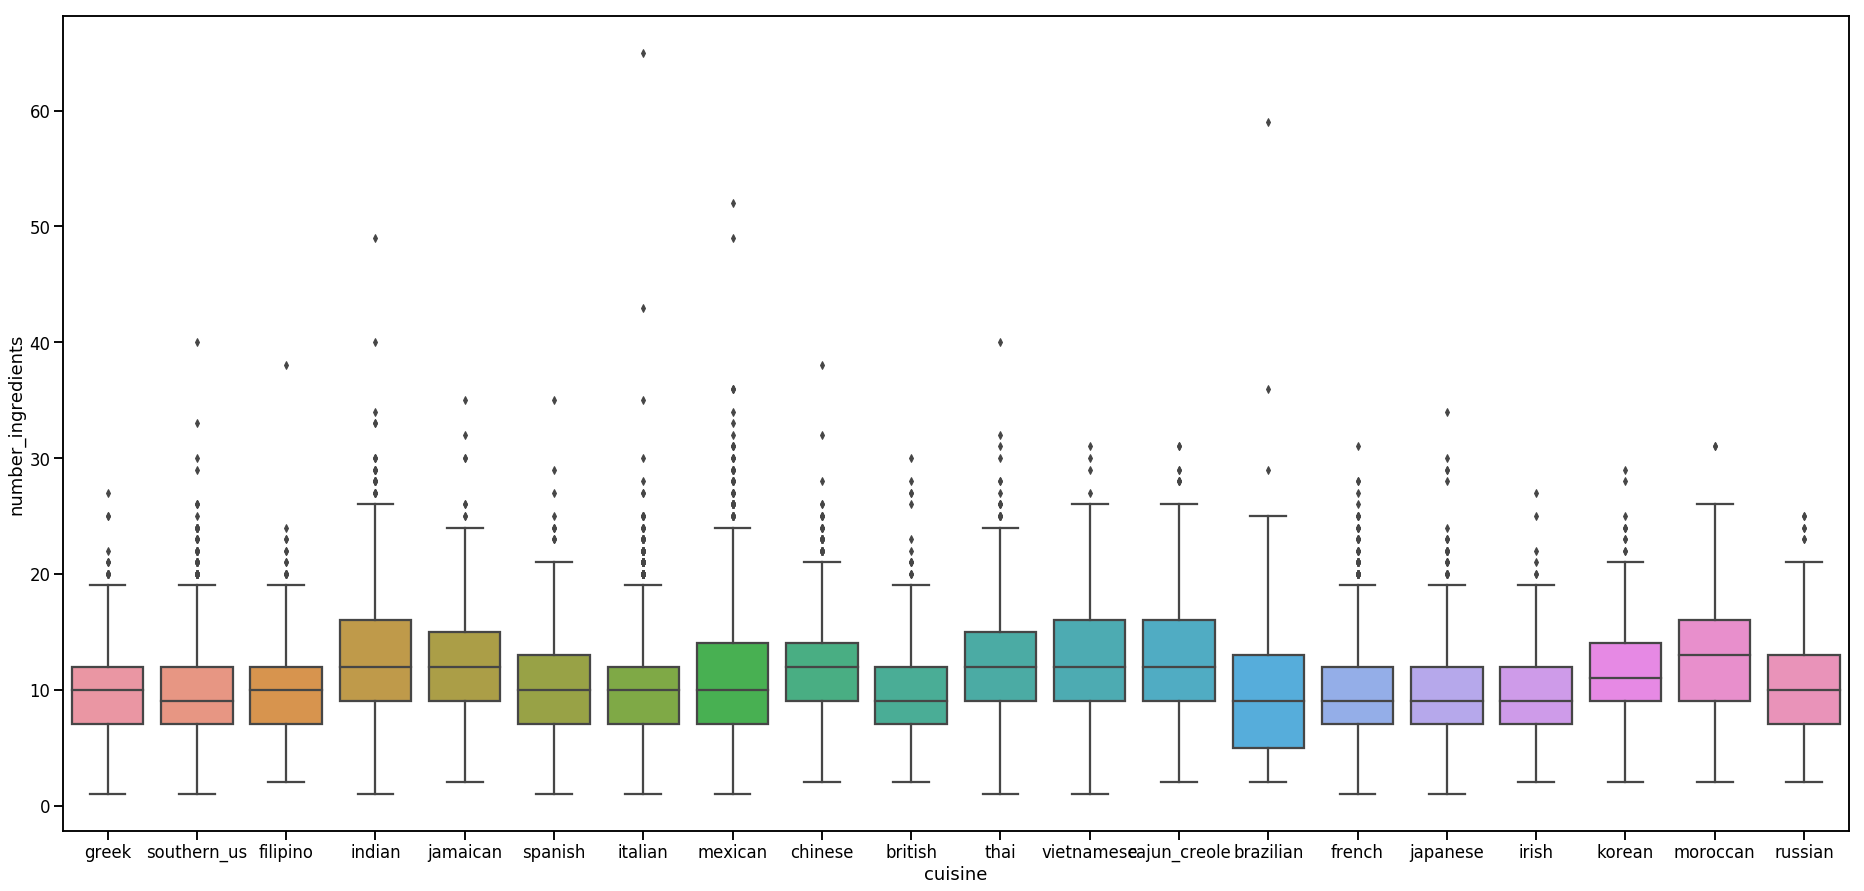

In [6]:
f, ax = plt.subplots(figsize=(32,15))
sns.boxplot(x='cuisine',
            y='number_ingredients',
            data= (pd.concat([traindf.cuisine,traindf.ingredients.map(lambda l: len(l))], axis=1)
                   .rename(columns={'ingredients':'number_ingredients'}))
            )


From the box plots of recipe length distributions, we can make several observations: <br>
- The Moroccan cuisine seems to have the longest recipes on average compared to all the other countries in our sample;
-  The Irish, British, French, Greek and Southern_us seems to have the shortest recipes;
- There exist outliers in all cuisines (some of them are extreme outliers like 65 for Italian we were talking about earlier);
- Most of the Asian cuisines (Vietnamese, Thai, Indian) seems to have larger recipes on average than most of the other countries ; 
- Recipes part of the European cuisine tend to be with average length or shorter compared to the rest of the sample which means that our 65 seems strongly innacurate.

####  Which are the most common ingredients in the whole training sample? 

In [19]:
ingredients_individual = Counter([ingredient for ingredient_list in traindf.ingredients for ingredient in ingredient_list])
ingredients_individual = pd.DataFrame.from_dict(ingredients_individual,orient='index').reset_index()

![](http://)Il y a 6714 ingrédients différents dans notre training set

####  And what about the test sample? 

In [20]:
ingredients_individualtest = Counter([ingredient for ingredient_list in testdf.ingredients for ingredient in ingredient_list])
ingredients_individualtest = pd.DataFrame.from_dict(ingredients_individualtest,orient='index').reset_index()

In [75]:
ingredients_individualtest.shape

(4484, 2)

![](http://)Il y a 4484 ingrédients différents dans notre training set

**Looklike there are differences between the two dataset, we need to watch out this. Lets see if we can visualise ingredient that are in the training set and not in the test set**

In [151]:
IngTrain = ingredients_individual['index']
IngTrain =set(IngTrain)

IngTest = ingredients_individualtest['index']
IngTest = set(IngTest)

diff1 = IngTrain.difference(IngTest)
diff1 = pd.DataFrame(diff1)
print(diff1.shape)

(2653, 1)


Il y a 2653 ingrédients présent dans le dataset train qui ne sont pas présent dans le dataset test. C'est de l'information qui ne sera pas utilisé dans notre étude, pour notre dataset test mais ça ne veux pas dire que cette information ne sera pas utile plus tard dans le cas ou notre modèle sera implémenté pour d'autres données avec d'autres recettes.

** Now let's visualise ingredient that aren't in the training set but are in the test set **

In [152]:
diff2 = IngTest.difference(IngTrain)
diff2 = pd.DataFrame(diff2)
print(diff2.shape)

(423, 1)


Il y a 423 ingrédients présent dans le test set qui ne sont pas présent dans le train set. Cela pourrait s'avérer problématique car l'algo mis en place n'aura pas ses infos implementé durant la phase d'apprentissage. Une solution envisageable pourrai être de remplacer ces ingrédients manquants par des ingrédients similaires mais présent dans le training set. 
which can be considered as a future opportunity for improvement of these models.

**Let's see the most common ingredient in the training sample**

In [ ]:
s1 = s1.rename(columns={'index':'Ingredient', 0:'Count'})

In [64]:
ingredients_individual = ingredients_individual.rename(columns={'index':'Ingredient', 0:'Count'})

In [52]:

print("The most common ingredients in our training sample:")
print("\n")
print(ingredients_individual.sort_values('Count', ascending=False).head(20))

The most common ingredients in our training sample:


              Ingredient  Count
11                  salt  18049
54             olive oil   7972
35                onions   7972
29                 water   7457
3                 garlic   7380
47                 sugar   6434
105        garlic cloves   6237
27                butter   4848
13   ground black pepper   4785
115    all-purpose flour   4632
4                 pepper   4438
19         vegetable oil   4385
15                  eggs   3388
26             soy sauce   3296
79           kosher salt   3113
228         green onions   3078
12              tomatoes   3058
204           large eggs   2948
200              carrots   2814
312      unsalted butter   2782


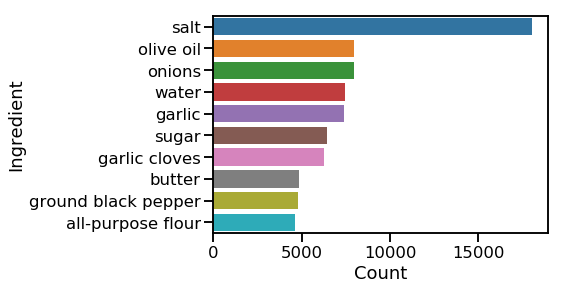

In [66]:
sns.barplot(x = 'Count', 
            y = 'Ingredient',
            data = ingredients_individual.sort_values('Count', ascending=False).head(10))

It seems that salt is the most commonly used ingredient. We also find water, onions, garlic and olive oil <br> 
Salt is such a common ingredient that we expect it to have poor predictive power in recognizing the type of cuisine.

We need to watch out garlic and garlic gloves, they seemed to be the same ingredient but with differents notations

And let's see the less common ingredient

In [11]:
ingredients_individual.sort_values('Count', ascending=False).tail(15)

,Ingredient,Count
5056,egg roll skins,1
5054,squid tube,1
5053,butternut,1
5050,low sodium fat free vegetable broth,1
5049,garbonzo bean,1
5048,whole garam masala,1
5043,rose hip tea bags,1
5042,small potatoes,1
5038,cherry syrup,1
5037,frozen fruit,1


### Top Bigrams by Cuisines

In [68]:
import nltk
from collections import Counter

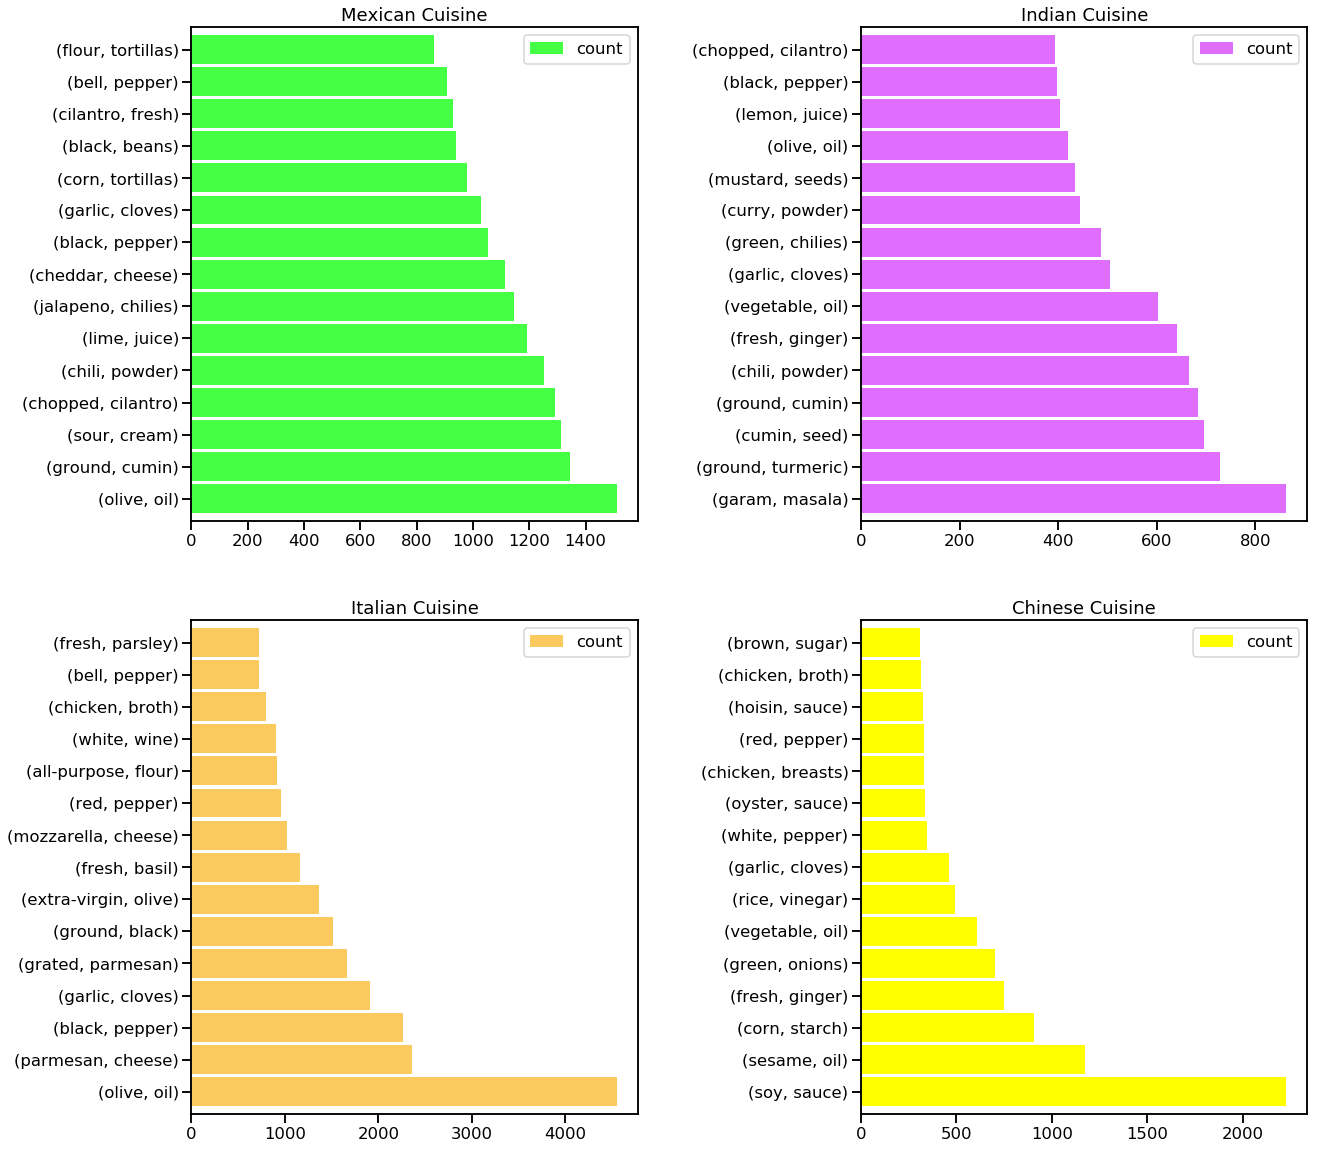

In [73]:
traindf['for ngrams']=traindf['ingredients_clean_string'].str.replace(',',' ')
f,ax=plt.subplots(2,2,figsize=(20,20))
def ingre_cusine(cuisine):
    frame=traindf[traindf['cuisine']==cuisine]
    common=list(nltk.bigrams(nltk.word_tokenize(" ".join(frame['for ngrams']))))
    return pd.DataFrame(Counter(common),index=['count']).T.sort_values('count',ascending=False)[:15]
ingre_cusine('mexican').plot.barh(ax=ax[0,0],width=0.9,color='#45ff45')
ax[0,0].set_title('Mexican Cuisine')
ingre_cusine('indian').plot.barh(ax=ax[0,1],width=0.9,color='#df6dfd')
ax[0,1].set_title('Indian Cuisine')
ingre_cusine('italian').plot.barh(ax=ax[1,0],width=0.9,color='#fbca5f')
ax[1,0].set_title('Italian Cuisine')
ingre_cusine('chinese').plot.barh(ax=ax[1,1],width=0.9,color='#ffff00')
ax[1,1].set_title('Chinese Cuisine')
plt.subplots_adjust(wspace=0.5)

### Let's see more in depth what are ingredients

In [4]:
df = pd.concat([traindf, testdf], sort=False)
df['ingredients_text'] = df['ingredients'].apply(lambda x: ', '.join(x))
df['num_ingredients'] = df['ingredients'].apply(lambda x: len(x))
raw_ingredients = [ingredient for ingredients in df.ingredients.values for ingredient in ingredients]
df.head()

,cuisine,id,ingredients,ingredients_text,num_ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes...","romaine lettuce, black olives, grape tomatoes,...",9
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g...","plain flour, ground pepper, salt, tomatoes, gr...",11
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g...","eggs, pepper, salt, mayonaise, cooking oil, gr...",12
3,indian,22213,"[water, vegetable oil, wheat, salt]","water, vegetable oil, wheat, salt",4
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe...","black pepper, shallots, cornflour, cayenne pep...",20


**i) Let's start by checking if all ingredients are valid**

For example, do ingredients consisting of less than 2 characters make sense?

In [17]:
[ingredient for ingredient in raw_ingredients if len(ingredient) <= 2]

['mi', 'mi', 'v8', 'v8', 'mi', 'la', 'mi', 'mi']

No that doesn't make any sense, in your preprocessing phase, we're going to get rid of them

**ii) Special characters**

See what special characters are contained.

  - "Bertolli**®** Alfredo Sauce"
  - "Progresso**™** Chicken Broth"
  - "green bell pepper**,** slice"
  - "half **&** half"
  - "asafetida **\(**powder**\)**"
  - "Spring**!** Water"

In [18]:
' '.join(sorted([char for char in set(' '.join(raw_ingredients)) if re.findall('[^A-Za-z]', char)]))

"  ! % & ' ( ) , - . / 0 1 2 3 4 5 6 7 8 9 ¢ § ¨ © ¬ \xad ® º Â Ã â ‚ „ € ™"

We will also get rid of them in our preprocessing phase

**iii) Upper cases**

It may be a proper noun.

- Company name
  - "**Oscar Mayer** Deli Fresh Smoked Ham"
- Region name
  - "**Shaoxing** wine"
  - "**California** bay leaves"
  - "**Italian** parsley leaves"

In [19]:
list(set([ingredient for ingredient in raw_ingredients if re.findall('[A-Z]+', ingredient)]))[:5]

['Morton Salt',
 'Ritz Crackers',
 'Amarena cherries',
 'Madras curry powder',
 'Kraft Mayonnaise']

There are just 5 cases but we will need to use lower()

**iv) Apostrophes**

In [5]:
list(set([ingredient for ingredient in raw_ingredients if '’' in ingredient]))

[]

It seems that there is no apostrophes in our ingredients

**v) Hyphens (-)**

In [29]:
list(set([ingredient for ingredient in raw_ingredients if re.findall('-', ingredient)]))[:5]

['fat-free parmesan cheese',
 'coarse-grain salt',
 'Wish-Bone Italian Dressing',
 'high-fructose corn syrup',
 'full-fat plain yogurt']

It might be okay to replace "-" with " ".

**vi) Numbers**

Numbers show quantity or density.

- "1% low-fat milk"
- "40% less sodium taco seasoning"
- "mexican style 4 cheese blend"

Strictly speaking, quantities can be a factor of identifying the cuisine but only a few ingredients come with quantity in this dataset.

In [30]:
list(set([ingredient for ingredient in raw_ingredients if re.findall('[0-9]', ingredient)]))[:5]

['40% less sodium taco seasoning mix',
 'YoplaitÂ® Greek 2% Key lime pie yogurt',
 'licor 43',
 '(14.5 oz.) diced tomatoes',
 '(15 oz.) refried beans']

Same here, we going to get rid of them later

**vii) Accents **

In [6]:
from ipywidgets import interact

accents = ['â', 'ç', 'è', 'é', 'í', 'î', 'ú']

@interact(accent=accents)
def f(accent):
    ingredients_df = pd.DataFrame([ingredient for ingredient in raw_ingredients if accent in ingredient], columns=['ingredient'])
    return ingredients_df.groupby(['ingredient']).size().reset_index(name='count').sort_values(['count'], ascending=False)

interactive(children=(Dropdown(description='accent', options=('â', 'ç', 'è', 'é', 'í', 'î', 'ú'), value='â'), Output()), _dom_classes=('widget-interact',))

Some accents are used only in a specific region. Can we use this information?

## II) What's cooking - Text Processing and Feature Engineering

### Preparation of ingredient list for tf idf

**TF** = Term Frequency, $tf_{td}=\frac{f_{td}}{\sum_{t'\in d}f_{td}}$, i.e. number of times term $t$ occurs in document $d$ ($f_{td}$) weighted by the number of words in document $d$. There are also other possible weights.

**IDF** = Inverse Document Frequency. IDF measures how much information a word provides (rare vs. common words). Given the number of documents $N$ and the number of documents $d$ that contain term $t$ ($\mathcal{D}_t$), it is defined as $idf_t=log(\frac{N}{|\mathcal{D}_t|})$.

**TF-IDF** = Term Frequency - Inverse Document Frequency, $tfidf_{td} = tf_{td}*idf_t$

*We will proceed the analysis by performing some simple data processing. The goal is to prepare the data for model development.*

In [9]:
from tqdm import tqdm
tqdm.pandas()
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import FunctionTransformer, LabelEncoder

In [10]:
traindf['num_ingredients'] = traindf['ingredients'].apply(lambda x: len(x))
testdf['num_ingredients'] = testdf['ingredients'].apply(lambda x: len(x))
#train['num_ingredients_2'] = train['ingredients'].apply(lambda x: len(x)*len(x))
#train['num_ingredients_log'] = train['ingredients'].apply(lambda x: log(len(x))
traindf = traindf[traindf['num_ingredients'] > 2]

In [11]:
lemmatizer = WordNetLemmatizer()
def preprocess(ingredients):
    ingredients_text = ' '.join(ingredients)
    ingredients_text = ingredients_text.lower() #remove upper case
    ingredients_text = ingredients_text.replace('-', '') #remove hyphens
    ingredients_text = ingredients_text.replace('wasabe', 'wasabi') #misspelings in the data
    ingredients_text = ingredients_text.replace('fish sauce', 'fishsauce')
    ingredients_text = ingredients_text.replace('coconut cream', 'coconutcream')
    ingredients_text = ingredients_text.replace('yellow onion', 'yellowonion')
    ingredients_text = ingredients_text.replace('cream cheese', 'creamcheese') 
    ingredients_text = ingredients_text.replace('baby spinach', 'babyspinach')
    ingredients_text = ingredients_text.replace('coriander seeds', 'corianderseeds')
    ingredients_text = ingredients_text.replace('corn tortillas', 'corntortillas')
    ingredients_text = ingredients_text.replace('rice cakes', 'ricecakes')
    words = []
    for word in ingredients_text.split():
        if re.findall('[0-9]', word): continue  #get rid of the numbers
        if len(word) <= 2: continue  #get rid of the ingredients with 2 characters or less
        if '’' in word: continue  #remove aposthrophe
        if re.findall('[^A-Za-z]', word): continue  #get rid of the special characters
            
        word = lemmatizer.lemmatize(word)  #Lemmatize is important because it seems than that dataset might 
                                           #have different representation of same words, like the olives and olive,
                                           #tomatoes and tomato, which represent the same word
        if len(word) > 0: words.append(word)
    return ' '.join(words)


In [12]:
traindf['x'] = traindf['ingredients'].progress_apply(lambda ingredients: preprocess(ingredients))
testdf['x'] = testdf['ingredients'].progress_apply(lambda ingredients: preprocess(ingredients))
traindf.head()

100%|████████████████████████████████████████████████████████████████████████████| 9944/9944 [00:01<00:00, 8205.98it/s]


,cuisine,id,ingredients,num_ingredients,x
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes...",9,romaine lettuce black olive grape tomato garli...
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g...",11,plain flour ground pepper salt tomato ground b...
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g...",12,egg pepper salt mayonaise cooking oil green ch...
3,indian,22213,"[water, vegetable oil, wheat, salt]",4,water vegetable oil wheat salt
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe...",20,black pepper shallot cornflour cayenne pepper ...


We saw in the previous part than the data needed some simple but important transformation like :

- Case normalization - Convert everything to lower.

- Removal of punctuation, digits or special characters - they are not considered as informative and correlated with the problem;

- Removal of different number - they can also be considered as not so related to the problem at hand and therefore can be excluded from further analysis. <br>

Performing this simple manipulation on data can give us confidence that a significant amount of 'noise' in our data is removed which is likely to lead to better results during the data modeling stage.

In [27]:
vectorizer = make_pipeline(
    TfidfVectorizer(sublinear_tf=True),
    FunctionTransformer(lambda x: x.astype('float'), validate=False)
)

predictors_tr = vectorizer.fit_transform(traindf['x'].values)
predictors_tr.sort_indices()
predictors_ts = vectorizer.transform(testdf['x'].values)

**During the feature engineering process we transform the textual data into more suitable format for performing mathematical operations and statistical learning techniques. In other words - we turn text into numbers. TfidfVectorizer have a matrix of number in output**

For now we choose to use only unigrams for building the prediction model. This means that in model development will be included features consisting of single words only. This can be considered as a good baseline and starting point for further analysis. <br> 

In [22]:
label_encoder = LabelEncoder()
targets_tr = label_encoder.fit_transform(traindf['cuisine'].values)
dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

{'brazilian': 0,
 'british': 1,
 'cajun_creole': 2,
 'chinese': 3,
 'filipino': 4,
 'french': 5,
 'greek': 6,
 'indian': 7,
 'irish': 8,
 'italian': 9,
 'jamaican': 10,
 'japanese': 11,
 'korean': 12,
 'mexican': 13,
 'moroccan': 14,
 'russian': 15,
 'southern_us': 16,
 'spanish': 17,
 'thai': 18,
 'vietnamese': 19}

In [32]:
#autre méthode

'''
traindf['ingredients_clean_string'] = [' , '.join(z).strip() for z in traindf['ingredients']] 
testdf['ingredients_clean_string'] = [' , '.join(z).strip() for z in testdf['ingredients']]

from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

corpustr = traindf['ingredients_clean_string']

vectorizertr = TfidfVectorizer(stop_words='english',
                               ngram_range = ( 1 , 1 ), # unigrams
                               analyzer="word",
                               tokenizer = LemmaTokenizer(),
                               token_pattern=r'\w+' ,
                               max_df = .57 , # any word appearing in more than 57% of the sample will be discarded
                               binary=False ,
                               sublinear_tf=False)

tfidftr=vectorizertr.fit_transform(corpustr).todense()
tfidfts=vectorizertr.transform(corpusts)



predictors_tr = tfidftr

targets_tr = traindf['cuisine']

predictors_ts = tfidfts

'''

## III) What's cooking - Modelisation

### Baseline Model with GridSearchCV for hyperparameter tuning

We built a function to make a GridSearchCV on a classifier and obtain some useful informations

In [19]:
def algo(algorithm,x_train,y_train,parameters) :
    
    classifier = GridSearchCV(algorithm, parameters, scoring = 'accuracy')
    classifier=classifier.fit(x_train,y_train)
    print(algorithm)
    print("\n Résultats de GridSearchCV : \n",pd.DataFrame(classifier.cv_results_))
    print("\n Best estimator : \n", classifier.best_estimator_)
    print("\n Best Parameter : \n", classifier.best_params_)
    print("\n Best Score (mean) : \n", classifier.best_score_)
    print("\n Best std (mean) : \n", classifier.cv_results_['std_test_score'][classifier.best_index_])

### Logistic regression

#### Hyperparameter tuning

In [20]:
parameters = {'C':[0.1, 1, 10,100, 1000], 'penalty' :('l1', 'l2')}
Logit = LogisticRegression() 

algo(Logit,predictors_tr,targets_tr,parameters)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

 Résultats de GridSearchCV : 
    mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0       1.840468      0.392609         0.022264        0.003983     0.1   
1       2.994248      0.253113         0.019974        0.000836     0.1   
2       3.603044      0.456136         0.021598        0.003085       1   
3       4.443736      0.264991         0.022601        0.003313       1   
4      11.504217      0.976139         0.021624        0.000481      10   
5       7.709876      0.324036         0.019261        0.000449      10   
6      33.012883      2.554083         0.022285        0.004012     100   
7      13.005517      0.650038         0.018617        0.000471     100   
8      76.965717      5.21124

*Les paramètres qui donnent la meilleur accuracy (0.7847) sont {'C': 10, 'penalty': 'l2',}, c'est ceux que l'on va utiliser pour la cross validation*

#### Cross Validation

In [209]:
Logit = LogisticRegression(C = 10, penalty = 'l2', solver = 'liblinear')

KFold = StratifiedKFold(n_splits=5, random_state=42)
scoresLG = cross_validate(Logit, predictors_tr,targets_tr, scoring="accuracy", cv=kfold)

In [210]:
pd.DataFrame(scoresLG)

,fit_time,score_time,test_score,train_score
0,10.353295,0.063829,0.784915,0.860524
1,10.383216,0.052858,0.791703,0.858198
2,10.343323,0.053856,0.788938,0.857035
3,10.014204,0.053856,0.779761,0.860586
4,11.866248,0.082778,0.795575,0.857260


## Linear SVC

#### Hyperparameter tuning

In [21]:
parameters = {'C' : [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], 'penalty' :('l1', 'l2')}

classifier = LinearSVC(dual=False)

algo(classifier,predictors_tr,targets_tr,parameters)


C:\Users\Evan\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Evan\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Evan\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Evan\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Evan\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", Conve

LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

 Résultats de GridSearchCV : 
     mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0        6.346447      0.749831         0.021607    3.092100e-03     0.1   
1        2.224704      0.122983         0.019956    8.140041e-04     0.1   
2        9.547785      0.364880         0.019309    4.706962e-04     0.2   
3        2.162879      0.040170         0.018975    1.783559e-05     0.2   
4       11.292135      0.671881         0.019622    9.525750e-04     0.3   
5        2.226044      0.093242         0.019632    9.277364e-04     0.3   
6       13.538790      0.467083         0.019291    4.829467e-04     0.4   
7        2.320457      0.078210         0.020301    9.364452e-04     0.4   
8       16.344578      1.216610         0.018949    3.371748e-07    

*Les paramètres qui donnent la meilleur accuracy (0.7871) sont {'C': 0.6, 'penalty': 'l2'}, c'est ceux que l'on va utiliser pour la cross validation*

#### Cross Validation

In [25]:
SVC = LinearSVC(C=0.6, dual=False, penalty = 'l2')

kfold = StratifiedKFold(n_splits=5, random_state=42)
scoresSVC = cross_validate(SVC, predictors_tr,targets_tr, scoring="accuracy", cv=kfold)

In [22]:
pd.DataFrame(scoresSVC)

,fit_time,score_time,test_score,train_score
0,3.282264,0.062783,0.788309,0.851724
1,3.309183,0.052820,0.794720,0.848078
2,3.293187,0.053856,0.789818,0.848581
3,3.234346,0.053855,0.784789,0.853327
4,3.331131,0.053811,0.796455,0.848334


In [26]:
pd.DataFrame(scoresSVC)

,fit_time,score_time,test_score,train_score
0,3.104031,0.003968,0.788889,0.854009
1,3.183969,0.004030,0.799116,0.851757
2,3.219999,0.004035,0.789913,0.851807
3,3.016000,0.004033,0.785055,0.855956
4,3.100000,0.004034,0.795294,0.852124


## Random Forest

#### Hyperparameter tuning

In [132]:
parameters = {'max_depth' :[3, 4, 5, 6, 7, 8], 'max_features' : ('auto', 'log2')}

classifier = RandomForestClassifier(n_estimators = 100)

algo(classifier,predictors_tr,targets_tr,parameters)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

 Résultats de GridSearchCV : 
     mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        5.682622      0.863951         0.471772        0.080183   
1        2.036965      0.039339         0.412220        0.006407   
2        6.553703      0.366409         0.505871        0.040299   
3        2.233685      0.057749         0.429186        0.008952   
4        7.937210      0.248780         0.461743        0.011979   
5        2.679151      0.051848         0.441667        0.011503   
6        9.138499      0.247780         0.490245        0.015916   

#### Cross Validation

In [23]:
RF = RandomForestClassifier(n_estimators = 750, max_depth = 8, max_features = 'auto')

kfold = KFold(n_splits=3, random_state=42)
scoresRF = cross_validate(RF, predictors_tr,targets_tr, scoring="accuracy", cv=kfold)

In [24]:
pd.DataFrame(scoresRF)

,fit_time,score_time,test_score,train_score
0,87.527468,3.201404,0.505129,0.513464
1,90.495063,3.191691,0.497813,0.509994
2,87.820161,3.222183,0.506487,0.508184


## Decision Tree

#### Hyperparameter tuning

In [144]:
parameters = {'max_depth' : [1, 5, 10, 30]
              , "min_samples_split": [2, 4
                                      
                                      , 10]
              , "max_features": [1, 3, 10]
              ,"min_samples_leaf": [1, 3, 10]
              ,"criterion": ["gini", "entropy"]}

classifier = DecisionTreeClassifier()

algo(classifier,predictors_tr,targets_tr,parameters)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

 Résultats de GridSearchCV : 
      mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         1.330174      0.874538         0.149932        0.020233   
1         0.732696      0.018593         0.144279        0.005888   
2         0.708440      0.001255         0.143290        0.000929   
3         0.762526      0.047112         0.159578        0.017000   
4         0.789810      0.105120         0.151595        0.010772   
5         0.691814      0.010624         0.134982        0.000483   
6         0.771272      0.046881         0.155917        0.023830   
7         0.777667      0.028643         0.146276        0.005755 

Les résultats obtenus par la GridSearCV ne sont pas du tout convaincant, je fais une cross validation sans trop d'espoir.

In [25]:
DT = DecisionTreeClassifier(criterion = 'entropy', max_depth = 30, max_features = 10, min_samples_leaf = 1, min_samples_split = 2)
scoresDT = ms.cross_validate(DT, predictors_tr,targets_tr, scoring="accuracy",
                        cv=5)

In [26]:
pd.DataFrame(scoresDT)

,fit_time,score_time,test_score,train_score
0,1.105156,0.102723,0.341246,0.390387
1,1.015474,0.107723,0.356622,0.404231
2,1.061845,0.101865,0.378582,0.460243
3,0.989434,0.090849,0.363351,0.418125
4,1.043766,0.093261,0.346168,0.397618


## Gradient Boosting

In [ ]:
GB = GradientBoostingClassifier()
scoresGB = ms.cross_validate(GB, predictors_tr,targets_tr, scoring="accuracy",
                        cv=2)

In [90]:
pd.DataFrame(scoresGB)

,fit_time,score_time,test_score
0,4868.854283,2.727768,0.726889
1,4752.475523,3.034741,0.729893


## LightGBM

#### Hyperparameter tuning

In [152]:
parameters = {'max_depth' : [3, 4, 5, 6, 7, 8]}

classifier = LGBMClassifier(n_estimators = 750, learning_rate = 0.01)

algo(classifier,predictors_tr,targets_tr,parameters)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.01, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=750, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

 Résultats de GridSearchCV : 
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0     198.553254      2.951300        13.947201        0.188578   
1     296.264122     11.634760        23.478257        1.751794   
2     415.151034     45.584533        34.132520        5.437131   
3     474.555254     16.123478        32.845897        1.432218   
4     586.524136     10.564044        35.457091        0.972975   
5     660.974923     17.898691        38.020360        1.047387   

  param_max_depth            params  split0_test_score  split1_test_score

*Le paramètre qui donnent la meilleur accuracy  est {'max_depth': 8}, c'est lui que l'on va utiliser pour la cross validation*

#### Cross Validation

In [28]:
lgbm_c = LGBMClassifier(n_estimators=750, learning_rate = 0.01, max_depth = 8)

kfold = KFold(n_splits=3, random_state=42)

scoreslgbm = ms.cross_validate(lgbm_c, predictors_tr,targets_tr, scoring="accuracy",
                        cv=kfold, return_train_score=False)

In [29]:
pd.DataFrame(scoreslgbm)

,fit_time,score_time,test_score
0,261.773440,9.737229,0.760975
1,249.103537,8.516248,0.757807
2,241.895575,10.627718,0.760824


## XGBoost

In [98]:
xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42)

In [99]:
kfold = KFold(n_splits=2, random_state=42)

scoresXGB = ms.cross_validate(xgb_model, predictors_tr,targets_tr, scoring="accuracy",
                        cv=kfold)


In [100]:
pd.DataFrame(scoresXGB)

C:\Users\Evan\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


,fit_time,score_time,test_score,train_score
0,3919.066379,16.541080,0.721426,0.775582
1,3575.349207,16.696635,0.724443,0.781666


## ExtraTree

#### HyperParameters tuning

In [158]:
parameters = {'n_estimators' : [10, 100, 300, 600]}

classifier = ExtraTreesClassifier()

algo(classifier,predictors_tr,targets_tr,parameters)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

 Résultats de GridSearchCV : 
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      12.594043      1.144729         0.456742        0.242573   
1     106.498354      3.731970         1.660313        0.077940   
2     336.451806     16.649036         5.118894        0.246908   
3     609.206235     14.249275       115.259140      123.694476   

  param_n_estimators                 params  split0_test_score  \
0                 10   {'n_estimators': 10}           0.714318   
1                100  {'n_estimators': 100}           0.762799   
2                300  {'

#### Cross validation

In [11]:
Extra_model = ExtraTreesClassifier(n_estimators = 850)

In [12]:
kfold = KFold(n_splits=4, random_state=42)

scoresET = ms.cross_validate(Extra_model, predictors_tr,targets_tr, scoring="accuracy",
                        cv=kfold)

In [19]:
pd.DataFrame(scoresET)

,fit_time,score_time,test_score,train_score
0,995.941314,103.894531,0.774940,0.999631
1,970.146786,82.346164,0.776649,0.999464
2,961.413986,104.766399,0.770995,0.999732
3,971.282524,94.658385,0.777733,0.999598


## IV) What's cooking - Models comparison

### Accuracy by algorithm

In [39]:
ar = np.array([[scoresLG['test_score'].mean(),
                scoresSVC['test_score'].mean(),
                scoresRF['test_score'].mean(),
                scoresDT['test_score'].mean(),
                scoresGB['test_score'].mean()),
                scoreslgbm['test_score'].mean(),
                scoresXGB['test_score'].mean(),
                scoresET['test_score'].mean(),
               ]])

    

df1 = pd.DataFrame(ar, index = ['Accuracy'], columns = ['Logistic Regression',
                                                        'Linear SVC',
                                                        'Random Forest',
                                                        'Decision Tree',
                                                        'Gradient Boosting',
                                                        'Light GBM',
                                                        'XGBoost',
                                                        'ExtraTree'])

In [48]:
df1

,Logistic Regression,Linear SVC,Random Forest,Decision Tree,Gradient Boosting,Light GBM,XGBoost,ExtraTree
Accuracy,0.789033,0.790818,0.503143,0.357194,0.728391,0.759868,0.722935,0.775079


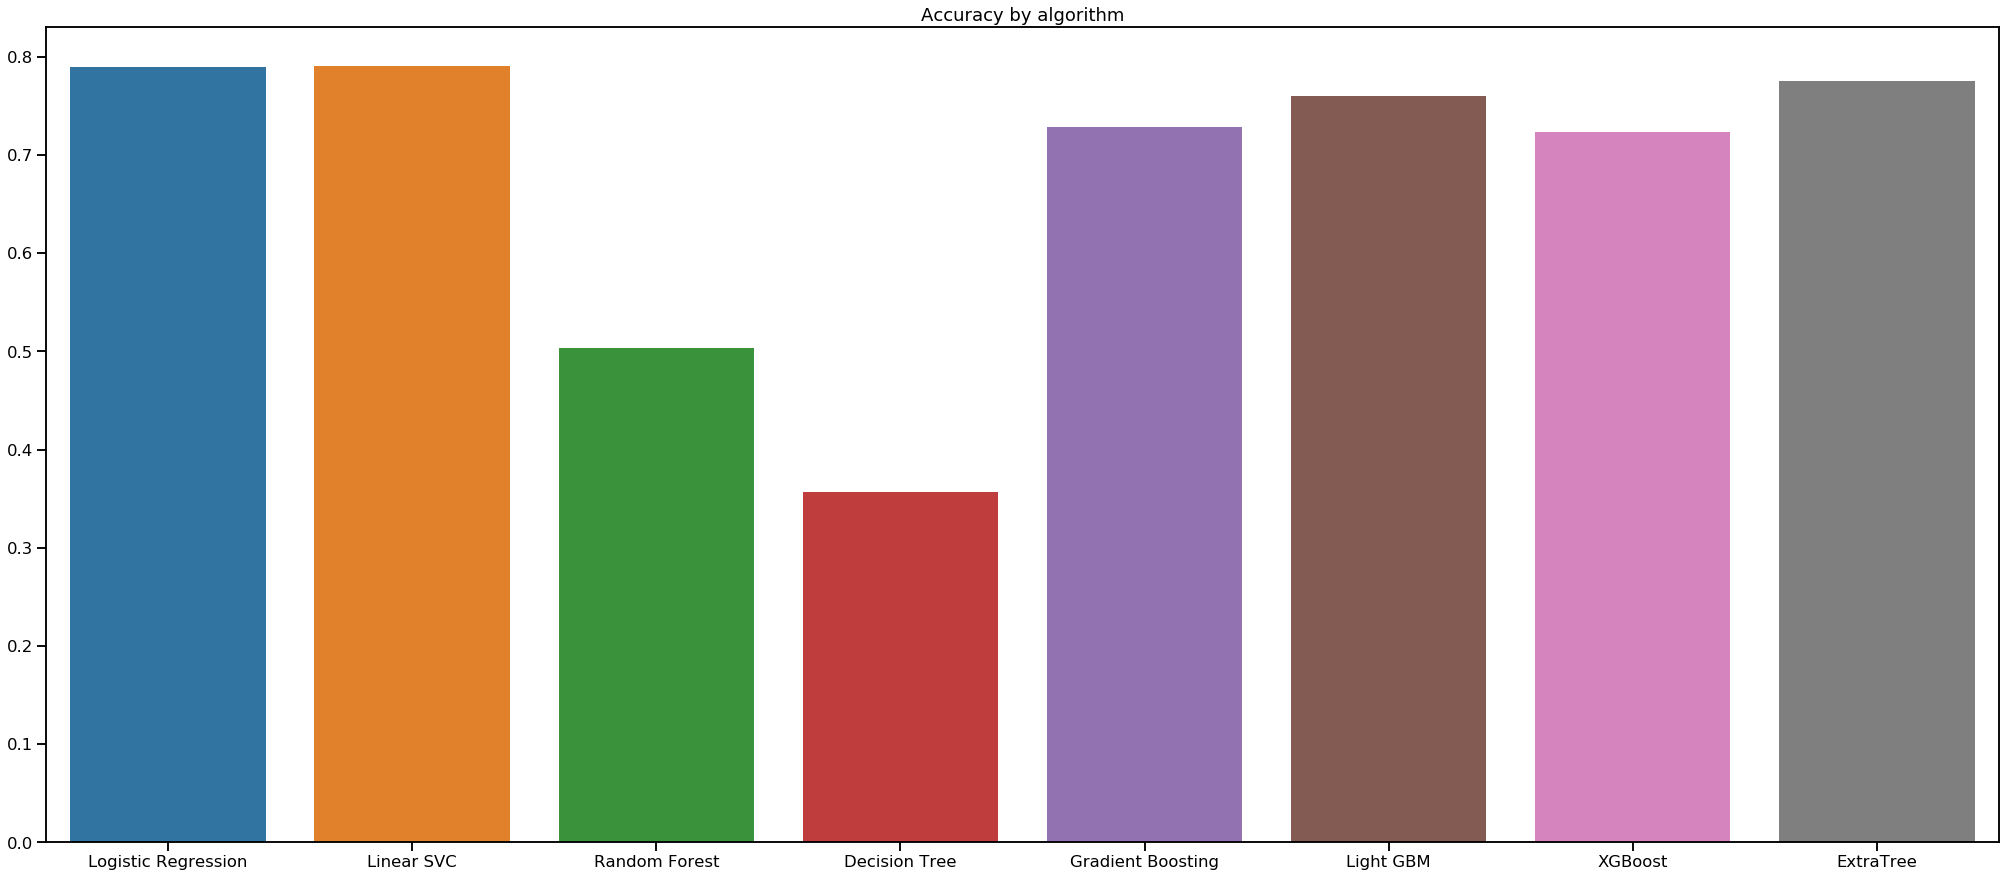

In [54]:
plt.figure(figsize=(35,15))
g = sns.barplot(data=df1)

plt.title("Accuracy by algorithm")
plt.show()

Except Random forest and Decision Tree who have very poor performances. All of the others models have a high accuracy, which is great ! The models that performs best are Logistic Regression and Linear SVC. With a slightly avantage for Linear SVC. 

### Variance by algorithm

In [43]:
ar = np.array([[scoresLG['test_score'].std(),
                scoresSVC['test_score'].std(),
                scoresRF['test_score'].std(),
                scoresDT['test_score'].std(),
                scoresGB['test_score'].std(),
                scoreslgbm['test_score'].std(),
                scoresXGB['test_score'].std(),
                scoresET['test_score'].std(),
               ]])

    

df2 = pd.DataFrame(ar, index = ['Variance'], columns = ['Logistic Regression',
                                                        'Linear SVC',
                                                        'Random Forest',
                                                        'Decision Tree',
                                                        'Gradient Boosting',
                                                        'Light GBM',
                                                        'XGBoost',
                                                        'ExtraTree'])

In [46]:
df2

,Logistic Regression,Linear SVC,Random Forest,Decision Tree,Gradient Boosting,Light GBM,XGBoost,ExtraTree
Variance,0.003801,0.004258,0.003809,0.013203,0.001502,0.001459,0.001508,0.00256


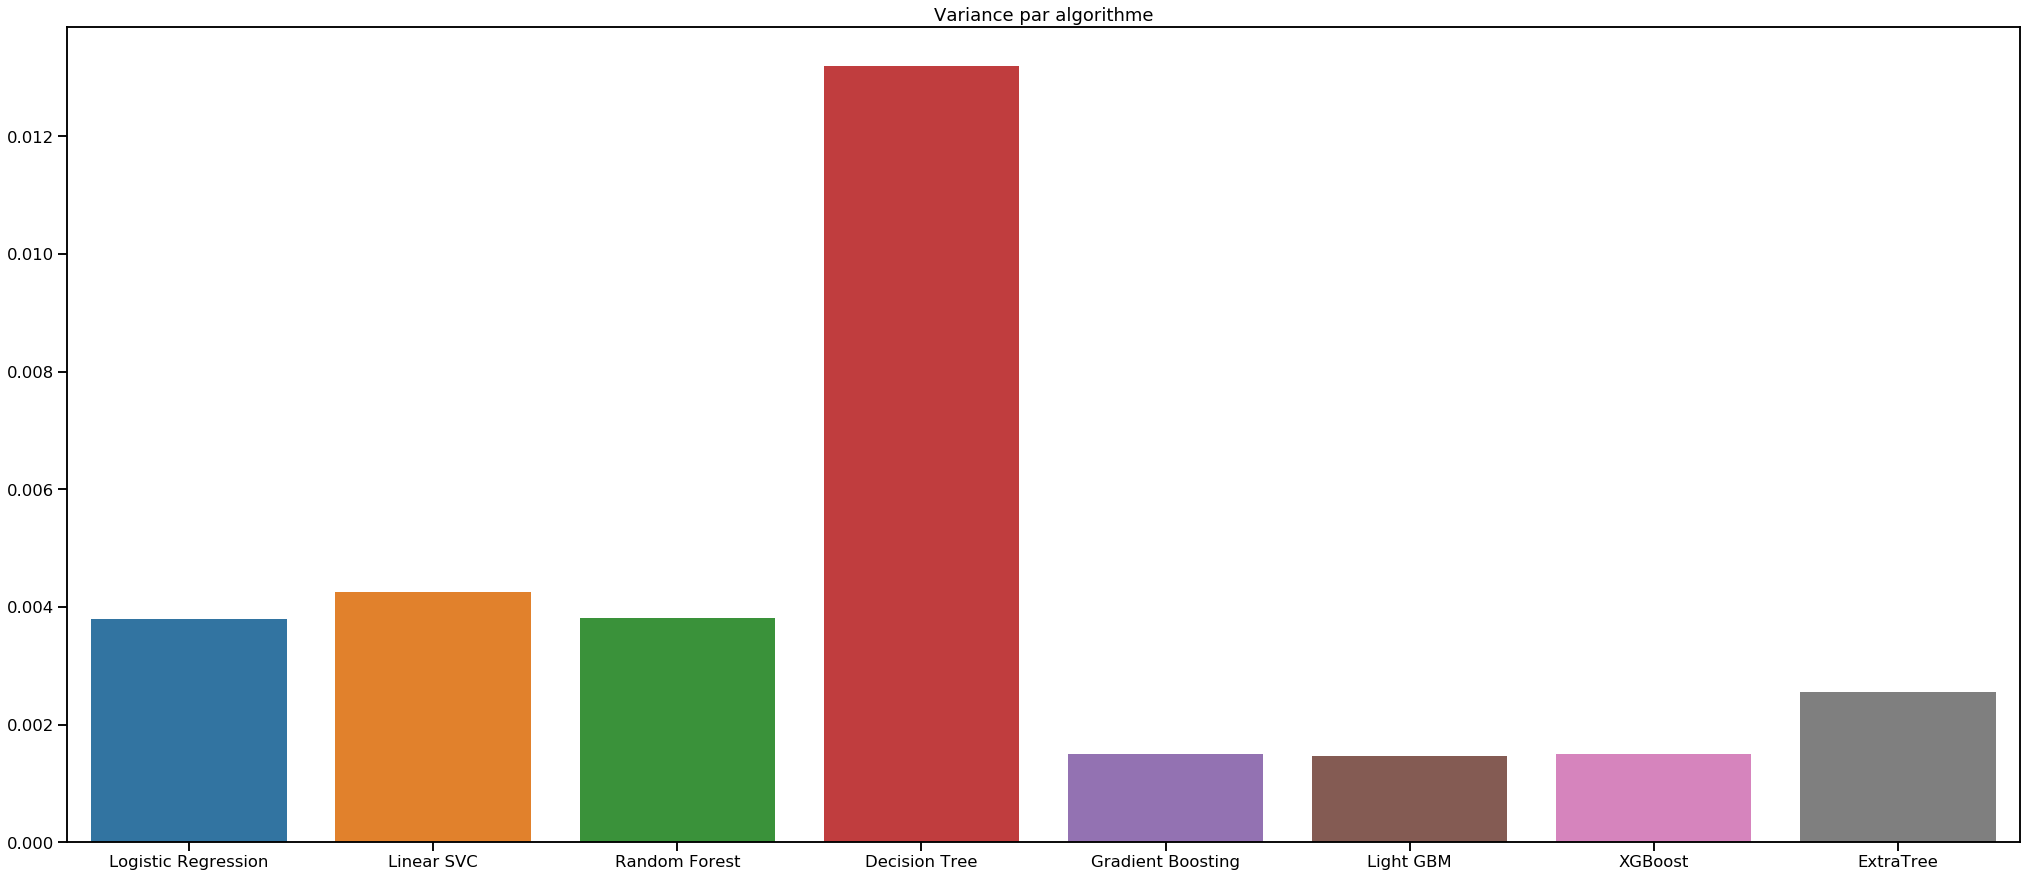

In [44]:
plt.figure(figsize=(35,15))
g = sns.barplot(data=df2)

plt.title("Variance by algorithm")
plt.show()

Except Decision Tree, all the models have very little variance.

### Execution time by algorithm

In [49]:
ar = np.array([[scoresLG['fit_time'].mean(),
                scoresSVC['fit_time'].mean(),
                scoresRF['fit_time'].mean(),
                scoresDT['fit_time'].mean(),
                scoresGB['fit_time'].mean(),
                scoreslgbm['fit_time'].mean(),
                scoresXGB['fit_time'].mean(),
                scoresET['fit_time'].mean(),
               ]])

    

df3 = pd.DataFrame(ar, index = ['Execution time'], columns = ['Logistic Regression',
                                                        'Linear SVC',
                                                        'Random Forest',
                                                        'Decision Tree',
                                                        'Gradient Boosting',
                                                        'Light GBM',
                                                        'XGBoost',
                                                        'ExtraTree'])

In [50]:
df3

,Logistic Regression,Linear SVC,Random Forest,Decision Tree,Gradient Boosting,Light GBM,XGBoost,ExtraTree
Execution time,11.088707,3.290022,88.614231,1.043135,4810.664903,0.759868,3747.207793,0.775079


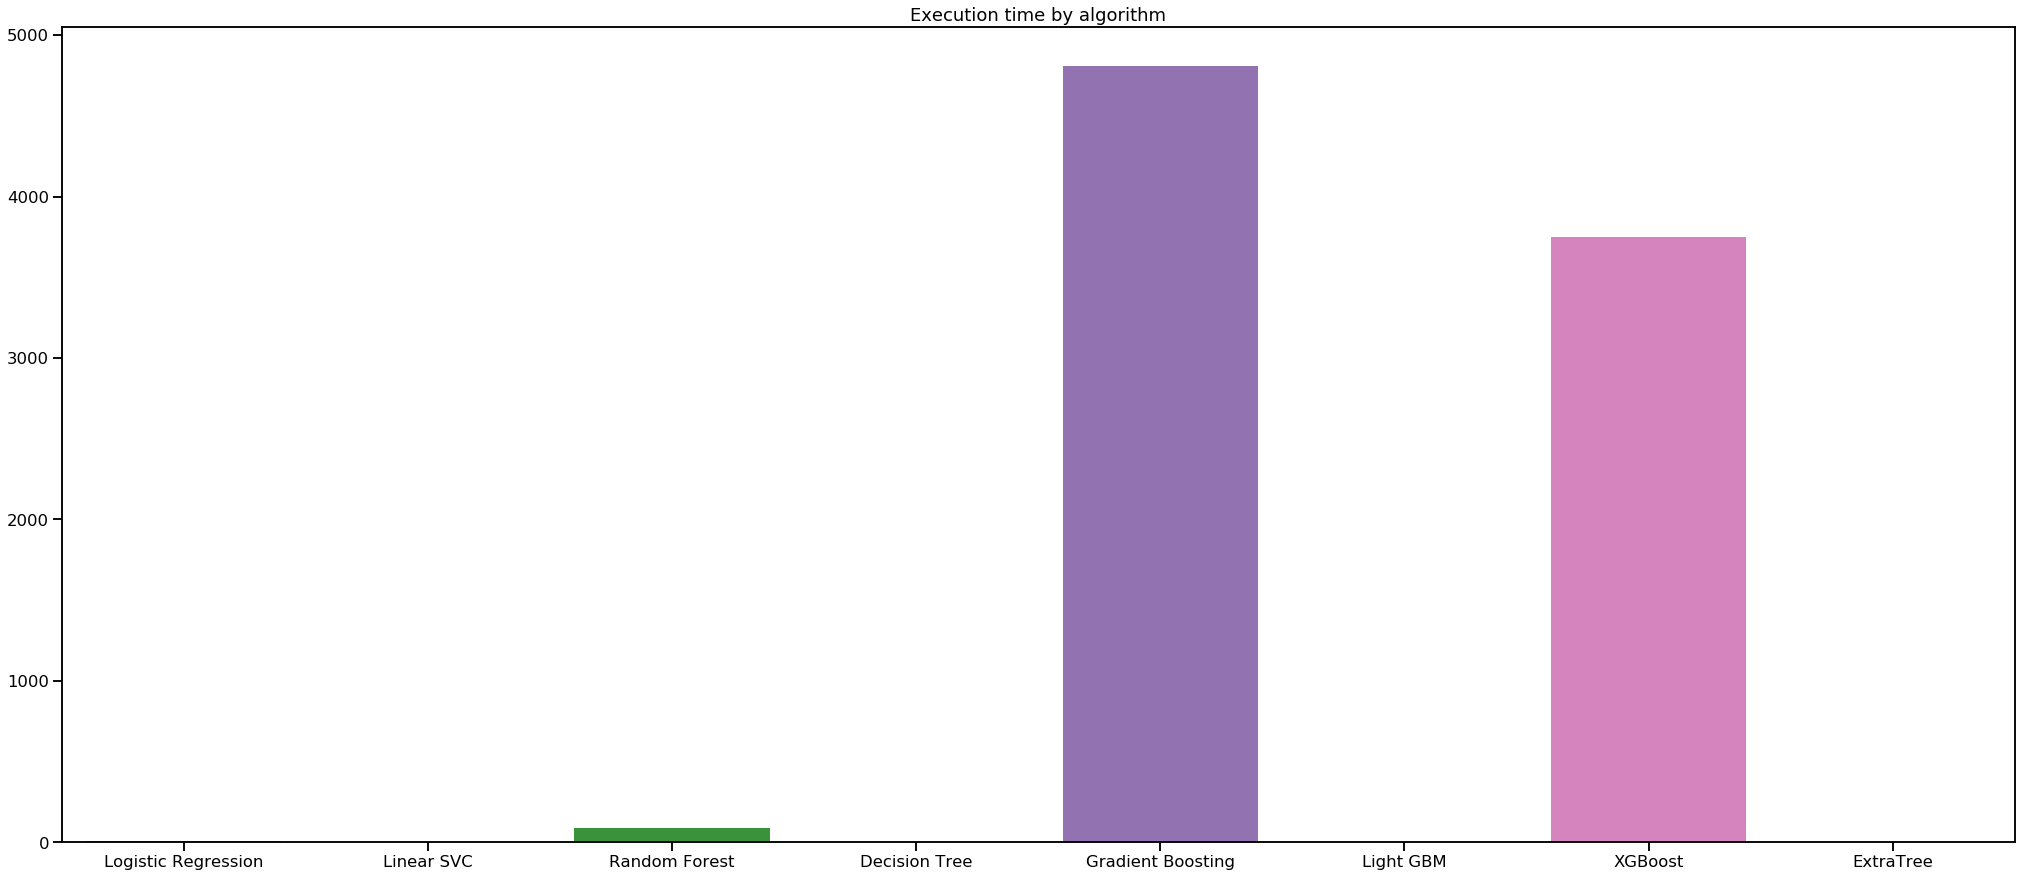

In [53]:
plt.figure(figsize=(35,15))
g = sns.barplot(data=df3)

plt.title("Execution time by algorithm")
plt.show()

That was predictable but Gradient boosting and XGBoost have a very long execution time. By far the longest time in our models. The boosting algorithm tend to perform better but they also tend to be computationally expensive

### All in one

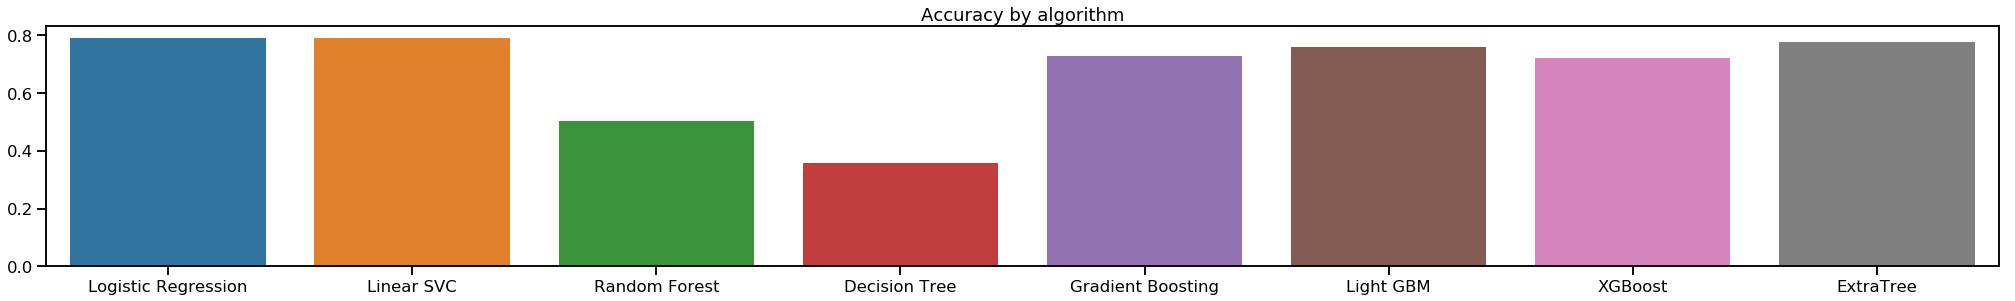

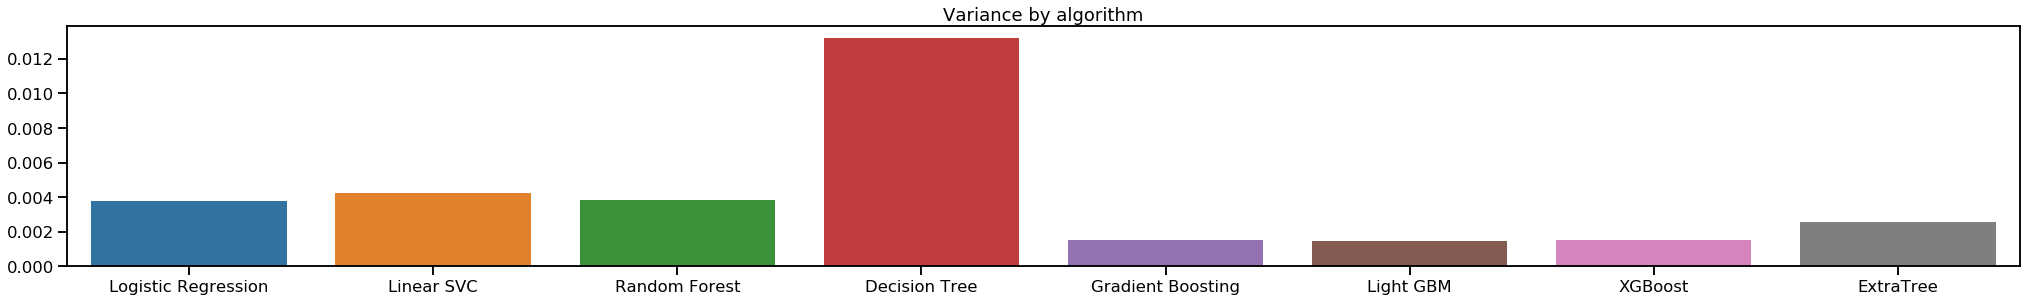

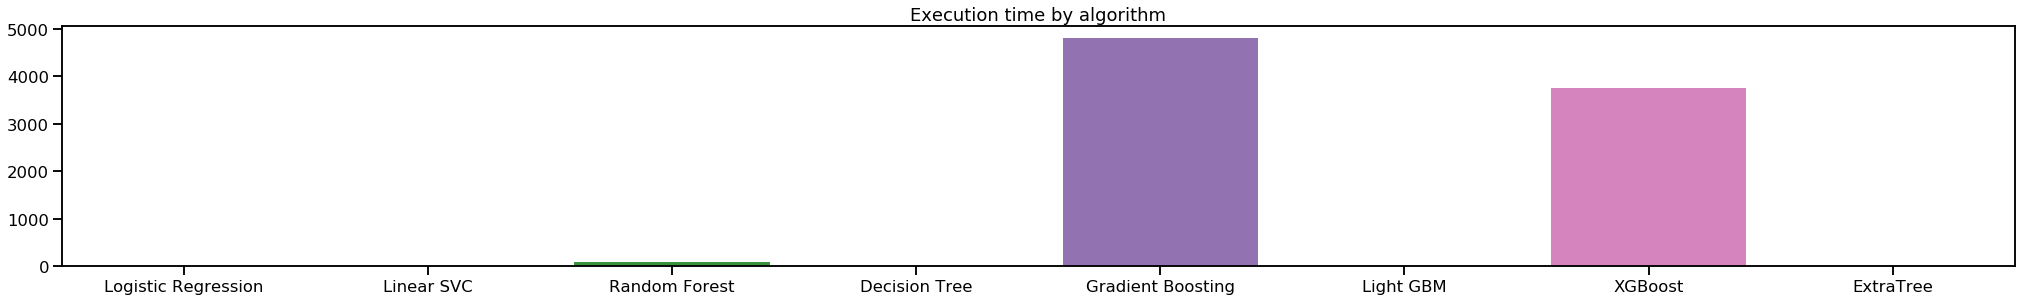

In [68]:
plt.figure(figsize=(35,15))
plt.subplot(311)
g = sns.barplot(data=df1)
plt.title("Accuracy by algorithm")
plt.show()

plt.figure(figsize=(35,15))
plt.subplot(312)
g = sns.barplot(data=df2)
plt.title("Variance by algorithm")
plt.show()

plt.figure(figsize=(35,15))
plt.subplot(313)
g = sns.barplot(data=df3)
plt.title("Execution time by algorithm")
plt.show()

Creating a Unigram Ensemble model was our first attempt  build some prediction models of the cuisine. I tried some hyperparameter tuning for some of them :

-Logistic Regression

-Linear SVC

-Random Forest

-Decision Tree

-Light GBM

-Extra Tree

No hyperparameter tuning was applied at this stage for Gradient Boosting and XGBoost, which can be considered as a future opportunity for improvement of these models.

It seems that is LinearSVC and Logistic regression who are doing best. These models are validated via 5-fold cross validation and the measured average accuracy on train sample is approximately 79% for both

Considering the results and the fact that we are using only unigrams (~3000 features only) - this is a good start. 

### Let's try to blend the best three classifier (Logistic Regression, Linear SVC and ExtraTreeClassifier)

In [13]:
# Ensemble Unigram model (baseline model) 
vclf=VotingClassifier(estimators=[('clf1',LogisticRegression(C = 10, penalty = 'l2', solver = 'liblinear')),
                                  ('clf2',LinearSVC(C=0.5, dual=False, penalty = 'l2')),
                                  ('clf3',ExtraTreesClassifier(n_estimators = 850))], 
                                    voting='hard', weights = [1,1,1]) 


In [ ]:
# 3-fold Cross validation of  the results
kfold = KFold(n_splits=3, random_state=42)
valscores = cross_validate(vclf, predictors_tr, targets_tr , scoring="accuracy", cv=kfold)

In [16]:
pd.DataFrame(valscores)

,fit_time,score_time,test_score,train_score
0,893.763016,149.797140,0.791598,0.874566
1,813.770284,96.534095,0.787525,0.874001
2,882.359703,88.408790,0.791447,0.873397


In [20]:
print('Mean accuracy on 3-fold cross validation: ' + str(np.mean(valscores['test_score']))) 

Mean accuracy on 3-fold cross validation: 0.7901895710765827


Our second attempt to build a prediction model of the cuisine consists of creating a Unigram Ensemble model which combines the decisions of the following three classifiers: 
- Logistic Regression;
- Linear Support Vector Classifier;
- ExtraTreeClassifier.

Predictions generated by the three classifiers are given equal weights in the final prediction.
The baseline model can be improved by using bigrams or higher order features (n-grams) stage which can be considered as a future opportunity for improvement of the predictive power of the model. <br><br>
Our VotingClassifier is validated via 3-fold cross validation and the measured average accuracy on train sample is 79.01%. <br><br> 


The result obtain on Kaggle is 0.79243, which is slightly better than LinearSVC and Logistic Regression. That's my best score for now. Not bad.

##  Generate predictions on test sample

*Some submit have been given to Kaggle but I will only show the best*

## VotingClassifier

In [27]:
vclf=VotingClassifier(estimators=[('clf1',LogisticRegression(C = 10, penalty = 'l2', solver = 'liblinear')),
                                  ('clf2',LinearSVC(C=0.6, dual=False, penalty = 'l2')),
                                  ('clf3',ExtraTreesClassifier(n_estimators = 850))], 
                                    voting='hard', weights = [1,1,1]) 
vclf.fit(predictors_tr, targets_tr)

VotingClassifier(estimators=[('clf1', LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)), ('clf2', ...tors=850, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=None, voting='hard',
         weights=[1, 1, 1])

In [31]:
predictions = label_encoder.inverse_transform(vclf.predict(predictors_ts) )
testdf['cuisine'] = predictions
testdf[['id', 'cuisine']].to_csv('submission.csv', index=False)

#predictions = vclf.predict(predictors_ts) 
#predictions_final = pd.DataFrame({'cuisine' : predictions , 'id' : testdf.id }, columns=['id', 'cuisine'])
#predictions_final.to_csv('Final_submission30.csv', index = False)

*Kaggle Score : 0.79243*

In [ ]:
#Feature selection

In [40]:

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


X_new = SelectKBest(chi2, k=2000).fit_transform(predictors_tr, targets_tr)
X_new.shape


(39774, 2000)

In [ ]:
vclf=VotingClassifier(estimators=[('clf1',LogisticRegression(C = 10, penalty = 'l2', solver = 'liblinear')),
                                  ('clf2',LinearSVC(C=0.6, dual=False, penalty = 'l2')),
                                  ('clf3',ExtraTreesClassifier(n_estimators = 850))], 
                                    voting='hard', weights = [1,1,1]) 
vclf.fit(X_new, targets_tr)

In [ ]:
predictions = vclf.predict(predictors_ts) 
predictions_final = pd.DataFrame({'cuisine' : predictions , 'id' : testdf.id }, columns=['id', 'cuisine'])
predictions_final.to_csv('Final_submission000.csv', index = False)